# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

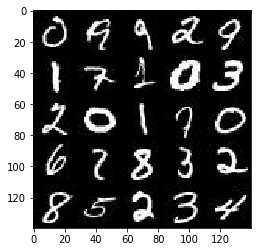

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

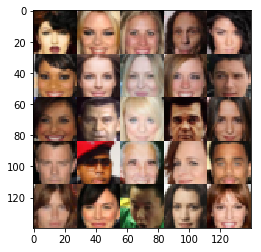

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, None)
    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xchannel
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out

    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # calculate losses
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    # Get weights and bias to update    
    t_vars = tf.trainable_variables()
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    height, width, channel = data_shape[1:]
    
    input_real, input_z, lr = model_inputs(width, height, channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    smooth = 0.1
    
    # determine how often to show sample image and print trainging stat
    print_per_epoch = 100
    show_per_epoch = 5
    total_samples = data_shape[0]
    total_batch_in_epoch = total_samples // batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for ii, batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model
                
                # normalize input
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                if ii > 0 and ii % (total_batch_in_epoch // print_per_epoch) == 0:
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = sess.run(g_loss, {input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                      "{:.2f}%...".format(ii * 100.0 / total_batch_in_epoch),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                
                if ii > 0 and ii % (total_batch_in_epoch // show_per_epoch) == 0:
                    show_generator_output(sess, 16, tf.random_uniform((16, z_dim)), channel, data_image_mode)

    print('finished training...')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... 0.85%... Discriminator Loss: 0.7140... Generator Loss: 2.7956
Epoch 1/2... 1.71%... Discriminator Loss: 0.4536... Generator Loss: 1.4951
Epoch 1/2... 2.56%... Discriminator Loss: 0.6404... Generator Loss: 4.5818
Epoch 1/2... 3.42%... Discriminator Loss: 0.1449... Generator Loss: 4.7289
Epoch 1/2... 4.27%... Discriminator Loss: 0.0813... Generator Loss: 3.9238
Epoch 1/2... 5.13%... Discriminator Loss: 0.1494... Generator Loss: 2.1792
Epoch 1/2... 5.98%... Discriminator Loss: 0.0154... Generator Loss: 5.9901
Epoch 1/2... 6.84%... Discriminator Loss: 0.0180... Generator Loss: 4.6574
Epoch 1/2... 7.69%... Discriminator Loss: 0.0211... Generator Loss: 4.5593
Epoch 1/2... 8.55%... Discriminator Loss: 0.0186... Generator Loss: 5.0976
Epoch 1/2... 9.40%... Discriminator Loss: 0.0195... Generator Loss: 5.0618
Epoch 1/2... 10.26%... Discriminator Loss: 0.6480... Generator Loss: 7.2252
Epoch 1/2... 11.11%... Discriminator Loss: 0.1849... Generator Loss: 7.2166
Epoch 1/2... 11.97%... 

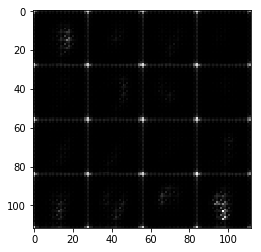

Epoch 1/2... 20.51%... Discriminator Loss: 1.1365... Generator Loss: 0.9548
Epoch 1/2... 21.37%... Discriminator Loss: 0.2829... Generator Loss: 2.9793
Epoch 1/2... 22.22%... Discriminator Loss: 0.7360... Generator Loss: 2.0427
Epoch 1/2... 23.08%... Discriminator Loss: 0.6405... Generator Loss: 1.7278
Epoch 1/2... 23.93%... Discriminator Loss: 0.3864... Generator Loss: 1.8075
Epoch 1/2... 24.79%... Discriminator Loss: 0.2469... Generator Loss: 2.8103
Epoch 1/2... 25.64%... Discriminator Loss: 0.2585... Generator Loss: 2.5364
Epoch 1/2... 26.50%... Discriminator Loss: 0.3577... Generator Loss: 2.3358
Epoch 1/2... 27.35%... Discriminator Loss: 0.5458... Generator Loss: 2.0718
Epoch 1/2... 28.21%... Discriminator Loss: 0.2770... Generator Loss: 2.6146
Epoch 1/2... 29.06%... Discriminator Loss: 0.3988... Generator Loss: 2.0119
Epoch 1/2... 29.91%... Discriminator Loss: 0.6060... Generator Loss: 1.6720
Epoch 1/2... 30.77%... Discriminator Loss: 0.6254... Generator Loss: 1.7317
Epoch 1/2...

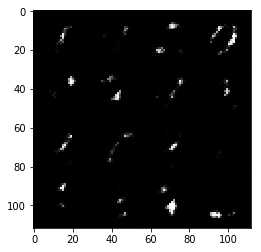

Epoch 1/2... 40.17%... Discriminator Loss: 0.3873... Generator Loss: 2.4108
Epoch 1/2... 41.03%... Discriminator Loss: 0.6528... Generator Loss: 2.3454
Epoch 1/2... 41.88%... Discriminator Loss: 0.8225... Generator Loss: 1.3291
Epoch 1/2... 42.74%... Discriminator Loss: 0.5259... Generator Loss: 1.5328
Epoch 1/2... 43.59%... Discriminator Loss: 0.3353... Generator Loss: 2.2741
Epoch 1/2... 44.44%... Discriminator Loss: 0.5437... Generator Loss: 2.1213
Epoch 1/2... 45.30%... Discriminator Loss: 0.7138... Generator Loss: 1.5595
Epoch 1/2... 46.15%... Discriminator Loss: 0.9937... Generator Loss: 3.4806
Epoch 1/2... 47.01%... Discriminator Loss: 0.5222... Generator Loss: 1.3238
Epoch 1/2... 47.86%... Discriminator Loss: 0.8440... Generator Loss: 0.9746
Epoch 1/2... 48.72%... Discriminator Loss: 0.4697... Generator Loss: 2.2150
Epoch 1/2... 49.57%... Discriminator Loss: 0.5953... Generator Loss: 1.6772
Epoch 1/2... 50.43%... Discriminator Loss: 1.2016... Generator Loss: 0.5572
Epoch 1/2...

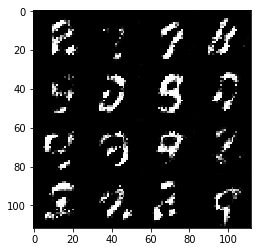

Epoch 1/2... 59.83%... Discriminator Loss: 0.2712... Generator Loss: 2.4590
Epoch 1/2... 60.68%... Discriminator Loss: 0.3879... Generator Loss: 2.5436
Epoch 1/2... 61.54%... Discriminator Loss: 0.3509... Generator Loss: 2.2629
Epoch 1/2... 62.39%... Discriminator Loss: 0.3655... Generator Loss: 1.9503
Epoch 1/2... 63.25%... Discriminator Loss: 0.2563... Generator Loss: 2.4433
Epoch 1/2... 64.10%... Discriminator Loss: 0.4960... Generator Loss: 1.4240
Epoch 1/2... 64.96%... Discriminator Loss: 2.2886... Generator Loss: 0.1860
Epoch 1/2... 65.81%... Discriminator Loss: 0.5197... Generator Loss: 1.9949
Epoch 1/2... 66.67%... Discriminator Loss: 0.7682... Generator Loss: 2.0672
Epoch 1/2... 67.52%... Discriminator Loss: 0.8280... Generator Loss: 1.2900
Epoch 1/2... 68.38%... Discriminator Loss: 0.7700... Generator Loss: 1.4346
Epoch 1/2... 69.23%... Discriminator Loss: 1.2146... Generator Loss: 1.5293
Epoch 1/2... 70.09%... Discriminator Loss: 1.7920... Generator Loss: 0.4834
Epoch 1/2...

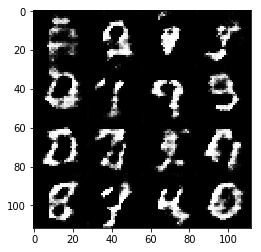

Epoch 1/2... 80.34%... Discriminator Loss: 0.6794... Generator Loss: 1.4330
Epoch 1/2... 81.20%... Discriminator Loss: 0.8772... Generator Loss: 1.1014
Epoch 1/2... 82.05%... Discriminator Loss: 1.1245... Generator Loss: 1.2552
Epoch 1/2... 82.91%... Discriminator Loss: 1.0067... Generator Loss: 1.7826
Epoch 1/2... 83.76%... Discriminator Loss: 0.8302... Generator Loss: 1.6323
Epoch 1/2... 84.62%... Discriminator Loss: 0.7293... Generator Loss: 1.3400
Epoch 1/2... 85.47%... Discriminator Loss: 0.8300... Generator Loss: 1.6833
Epoch 1/2... 86.32%... Discriminator Loss: 0.7746... Generator Loss: 1.1774
Epoch 1/2... 87.18%... Discriminator Loss: 0.8326... Generator Loss: 1.3709
Epoch 1/2... 88.03%... Discriminator Loss: 0.7304... Generator Loss: 1.6621
Epoch 1/2... 88.89%... Discriminator Loss: 0.9537... Generator Loss: 1.1618
Epoch 1/2... 89.74%... Discriminator Loss: 0.7350... Generator Loss: 1.7962
Epoch 1/2... 90.60%... Discriminator Loss: 0.6134... Generator Loss: 1.8771
Epoch 1/2...

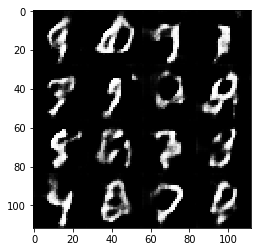

Epoch 2/2... 0.85%... Discriminator Loss: 1.0555... Generator Loss: 0.6738
Epoch 2/2... 1.71%... Discriminator Loss: 0.7904... Generator Loss: 2.1626
Epoch 2/2... 2.56%... Discriminator Loss: 0.6518... Generator Loss: 1.5081
Epoch 2/2... 3.42%... Discriminator Loss: 0.8608... Generator Loss: 1.0177
Epoch 2/2... 4.27%... Discriminator Loss: 0.7686... Generator Loss: 1.3243
Epoch 2/2... 5.13%... Discriminator Loss: 0.5626... Generator Loss: 1.4491
Epoch 2/2... 5.98%... Discriminator Loss: 0.7047... Generator Loss: 1.9382
Epoch 2/2... 6.84%... Discriminator Loss: 0.7240... Generator Loss: 1.2312
Epoch 2/2... 7.69%... Discriminator Loss: 0.8264... Generator Loss: 1.8129
Epoch 2/2... 8.55%... Discriminator Loss: 1.1019... Generator Loss: 2.3398
Epoch 2/2... 9.40%... Discriminator Loss: 0.6126... Generator Loss: 1.7304
Epoch 2/2... 10.26%... Discriminator Loss: 0.7265... Generator Loss: 1.1755
Epoch 2/2... 11.11%... Discriminator Loss: 0.7063... Generator Loss: 1.1265
Epoch 2/2... 11.97%... 

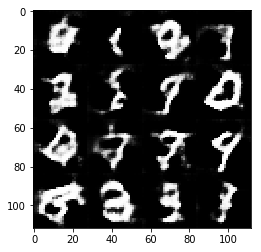

Epoch 2/2... 20.51%... Discriminator Loss: 0.6064... Generator Loss: 1.5765
Epoch 2/2... 21.37%... Discriminator Loss: 0.6939... Generator Loss: 1.4669
Epoch 2/2... 22.22%... Discriminator Loss: 0.7561... Generator Loss: 1.2561
Epoch 2/2... 23.08%... Discriminator Loss: 0.8478... Generator Loss: 1.1679
Epoch 2/2... 23.93%... Discriminator Loss: 0.8010... Generator Loss: 1.4522
Epoch 2/2... 24.79%... Discriminator Loss: 0.8009... Generator Loss: 1.0897
Epoch 2/2... 25.64%... Discriminator Loss: 0.5968... Generator Loss: 1.8992
Epoch 2/2... 26.50%... Discriminator Loss: 0.8407... Generator Loss: 1.1383
Epoch 2/2... 27.35%... Discriminator Loss: 0.7267... Generator Loss: 1.2461
Epoch 2/2... 28.21%... Discriminator Loss: 0.7727... Generator Loss: 1.1615
Epoch 2/2... 29.06%... Discriminator Loss: 0.7349... Generator Loss: 1.3285
Epoch 2/2... 29.91%... Discriminator Loss: 0.7736... Generator Loss: 1.5383
Epoch 2/2... 30.77%... Discriminator Loss: 0.6860... Generator Loss: 1.3784
Epoch 2/2...

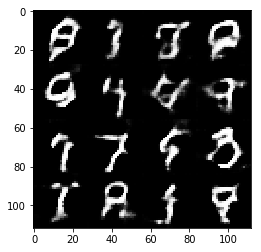

Epoch 2/2... 40.17%... Discriminator Loss: 0.9274... Generator Loss: 1.0251
Epoch 2/2... 41.03%... Discriminator Loss: 0.9165... Generator Loss: 1.2859
Epoch 2/2... 41.88%... Discriminator Loss: 0.6879... Generator Loss: 1.6375
Epoch 2/2... 42.74%... Discriminator Loss: 0.7214... Generator Loss: 1.6335
Epoch 2/2... 43.59%... Discriminator Loss: 0.7897... Generator Loss: 1.4352
Epoch 2/2... 44.44%... Discriminator Loss: 1.0903... Generator Loss: 2.4209
Epoch 2/2... 45.30%... Discriminator Loss: 0.7444... Generator Loss: 1.6132
Epoch 2/2... 46.15%... Discriminator Loss: 0.6953... Generator Loss: 1.3633
Epoch 2/2... 47.01%... Discriminator Loss: 0.9833... Generator Loss: 1.4751
Epoch 2/2... 47.86%... Discriminator Loss: 0.8513... Generator Loss: 1.3670
Epoch 2/2... 48.72%... Discriminator Loss: 0.6190... Generator Loss: 1.7405
Epoch 2/2... 49.57%... Discriminator Loss: 0.8603... Generator Loss: 1.1911
Epoch 2/2... 50.43%... Discriminator Loss: 0.7069... Generator Loss: 1.3623
Epoch 2/2...

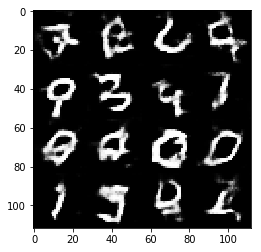

Epoch 2/2... 59.83%... Discriminator Loss: 0.7111... Generator Loss: 1.6604
Epoch 2/2... 60.68%... Discriminator Loss: 0.9228... Generator Loss: 0.9991
Epoch 2/2... 61.54%... Discriminator Loss: 0.8617... Generator Loss: 1.7913
Epoch 2/2... 62.39%... Discriminator Loss: 0.5990... Generator Loss: 1.3463
Epoch 2/2... 63.25%... Discriminator Loss: 0.6744... Generator Loss: 1.6764
Epoch 2/2... 64.10%... Discriminator Loss: 0.8304... Generator Loss: 1.1862
Epoch 2/2... 64.96%... Discriminator Loss: 0.9409... Generator Loss: 0.8022
Epoch 2/2... 65.81%... Discriminator Loss: 0.6661... Generator Loss: 1.7478
Epoch 2/2... 66.67%... Discriminator Loss: 0.7569... Generator Loss: 1.2883
Epoch 2/2... 67.52%... Discriminator Loss: 0.7077... Generator Loss: 1.2852
Epoch 2/2... 68.38%... Discriminator Loss: 0.7071... Generator Loss: 1.4562
Epoch 2/2... 69.23%... Discriminator Loss: 0.6287... Generator Loss: 1.7356
Epoch 2/2... 70.09%... Discriminator Loss: 0.7814... Generator Loss: 1.6792
Epoch 2/2...

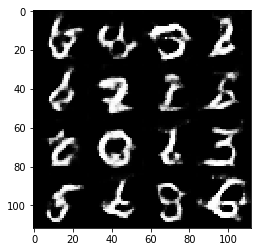

Epoch 2/2... 80.34%... Discriminator Loss: 0.6201... Generator Loss: 1.6164
Epoch 2/2... 81.20%... Discriminator Loss: 0.6623... Generator Loss: 1.5302
Epoch 2/2... 82.05%... Discriminator Loss: 0.6464... Generator Loss: 1.3220
Epoch 2/2... 82.91%... Discriminator Loss: 0.6159... Generator Loss: 1.4858
Epoch 2/2... 83.76%... Discriminator Loss: 0.5634... Generator Loss: 1.8777
Epoch 2/2... 84.62%... Discriminator Loss: 0.7013... Generator Loss: 1.0243
Epoch 2/2... 85.47%... Discriminator Loss: 0.6330... Generator Loss: 1.4597
Epoch 2/2... 86.32%... Discriminator Loss: 0.5439... Generator Loss: 1.5422
Epoch 2/2... 87.18%... Discriminator Loss: 0.7100... Generator Loss: 1.4393
Epoch 2/2... 88.03%... Discriminator Loss: 0.7330... Generator Loss: 1.0406
Epoch 2/2... 88.89%... Discriminator Loss: 0.5739... Generator Loss: 1.4229
Epoch 2/2... 89.74%... Discriminator Loss: 0.6053... Generator Loss: 1.4511
Epoch 2/2... 90.60%... Discriminator Loss: 0.6157... Generator Loss: 1.8379
Epoch 2/2...

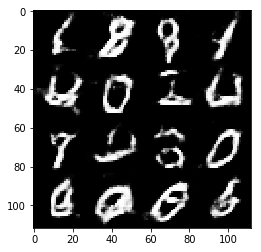

finished training...


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.7


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... 0.95%... Discriminator Loss: 0.0921... Generator Loss: 4.6787
Epoch 1/2... 1.90%... Discriminator Loss: 0.1830... Generator Loss: 2.5755
Epoch 1/2... 2.84%... Discriminator Loss: 0.0236... Generator Loss: 7.7336
Epoch 1/2... 3.79%... Discriminator Loss: 0.2226... Generator Loss: 1.9260
Epoch 1/2... 4.74%... Discriminator Loss: 0.0422... Generator Loss: 6.7955
Epoch 1/2... 5.69%... Discriminator Loss: 0.2268... Generator Loss: 2.4502
Epoch 1/2... 6.64%... Discriminator Loss: 0.3278... Generator Loss: 2.8324
Epoch 1/2... 7.59%... Discriminator Loss: 0.1726... Generator Loss: 2.7915
Epoch 1/2... 8.53%... Discriminator Loss: 0.1473... Generator Loss: 2.8755
Epoch 1/2... 9.48%... Discriminator Loss: 0.0378... Generator Loss: 5.9082
Epoch 1/2... 10.43%... Discriminator Loss: 0.0337... Generator Loss: 4.8269
Epoch 1/2... 11.38%... Discriminator Loss: 0.0169... Generator Loss: 5.2071
Epoch 1/2... 12.33%... Discriminator Loss: 0.0065... Generator Loss: 6.6854
Epoch 1/2... 13.27%...

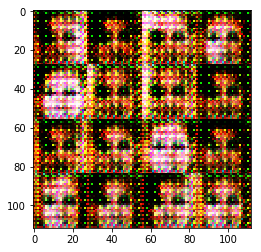

Epoch 1/2... 20.86%... Discriminator Loss: 2.3562... Generator Loss: 0.2129
Epoch 1/2... 21.81%... Discriminator Loss: 0.5845... Generator Loss: 1.2930
Epoch 1/2... 22.76%... Discriminator Loss: 0.1281... Generator Loss: 4.3842
Epoch 1/2... 23.70%... Discriminator Loss: 0.4610... Generator Loss: 2.1541
Epoch 1/2... 24.65%... Discriminator Loss: 0.3053... Generator Loss: 3.4394
Epoch 1/2... 25.60%... Discriminator Loss: 0.6616... Generator Loss: 1.7019
Epoch 1/2... 26.55%... Discriminator Loss: 0.5744... Generator Loss: 2.3342
Epoch 1/2... 27.50%... Discriminator Loss: 0.4059... Generator Loss: 1.8683
Epoch 1/2... 28.45%... Discriminator Loss: 0.7450... Generator Loss: 1.2811
Epoch 1/2... 29.39%... Discriminator Loss: 0.6471... Generator Loss: 1.3245
Epoch 1/2... 30.34%... Discriminator Loss: 0.6105... Generator Loss: 1.8504
Epoch 1/2... 31.29%... Discriminator Loss: 1.0104... Generator Loss: 0.9645
Epoch 1/2... 32.24%... Discriminator Loss: 0.4022... Generator Loss: 2.8387
Epoch 1/2...

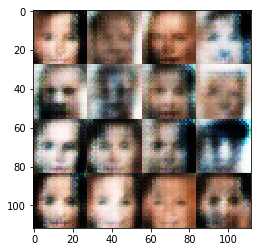

Epoch 1/2... 40.77%... Discriminator Loss: 1.0987... Generator Loss: 1.0750
Epoch 1/2... 41.72%... Discriminator Loss: 0.5954... Generator Loss: 1.7226
Epoch 1/2... 42.67%... Discriminator Loss: 0.9235... Generator Loss: 1.4625
Epoch 1/2... 43.62%... Discriminator Loss: 0.9684... Generator Loss: 1.5199
Epoch 1/2... 44.56%... Discriminator Loss: 0.7420... Generator Loss: 1.5753
Epoch 1/2... 45.51%... Discriminator Loss: 1.3917... Generator Loss: 0.4904
Epoch 1/2... 46.46%... Discriminator Loss: 0.9081... Generator Loss: 1.3334
Epoch 1/2... 47.41%... Discriminator Loss: 1.0344... Generator Loss: 1.0809
Epoch 1/2... 48.36%... Discriminator Loss: 0.7655... Generator Loss: 1.8067
Epoch 1/2... 49.30%... Discriminator Loss: 0.7993... Generator Loss: 1.3342
Epoch 1/2... 50.25%... Discriminator Loss: 1.1217... Generator Loss: 0.9115
Epoch 1/2... 51.20%... Discriminator Loss: 0.9745... Generator Loss: 0.9002
Epoch 1/2... 52.15%... Discriminator Loss: 0.9977... Generator Loss: 1.2299
Epoch 1/2...

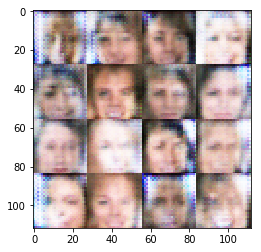

Epoch 1/2... 60.68%... Discriminator Loss: 3.8323... Generator Loss: 0.2802
Epoch 1/2... 61.63%... Discriminator Loss: 0.5780... Generator Loss: 1.5397
Epoch 1/2... 62.58%... Discriminator Loss: 0.6090... Generator Loss: 1.5087
Epoch 1/2... 63.53%... Discriminator Loss: 1.1210... Generator Loss: 0.8450
Epoch 1/2... 64.48%... Discriminator Loss: 1.2602... Generator Loss: 0.8373
Epoch 1/2... 65.42%... Discriminator Loss: 1.7533... Generator Loss: 0.7948
Epoch 1/2... 66.37%... Discriminator Loss: 1.1828... Generator Loss: 0.8865
Epoch 1/2... 67.32%... Discriminator Loss: 1.0045... Generator Loss: 1.1909
Epoch 1/2... 68.27%... Discriminator Loss: 1.1776... Generator Loss: 1.0703
Epoch 1/2... 69.22%... Discriminator Loss: 1.0661... Generator Loss: 0.8593
Epoch 1/2... 70.16%... Discriminator Loss: 0.6847... Generator Loss: 1.6170
Epoch 1/2... 71.11%... Discriminator Loss: 0.9677... Generator Loss: 1.3511
Epoch 1/2... 72.06%... Discriminator Loss: 1.0539... Generator Loss: 1.1596
Epoch 1/2...

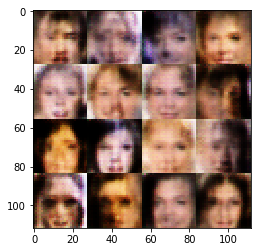

Epoch 1/2... 80.59%... Discriminator Loss: 1.5294... Generator Loss: 0.6673
Epoch 1/2... 81.54%... Discriminator Loss: 1.2788... Generator Loss: 0.6768
Epoch 1/2... 82.49%... Discriminator Loss: 1.0267... Generator Loss: 1.0221
Epoch 1/2... 83.44%... Discriminator Loss: 1.0081... Generator Loss: 1.1056
Epoch 1/2... 84.39%... Discriminator Loss: 1.2326... Generator Loss: 0.9011
Epoch 1/2... 85.34%... Discriminator Loss: 1.0957... Generator Loss: 1.1959
Epoch 1/2... 86.28%... Discriminator Loss: 1.3516... Generator Loss: 0.9829
Epoch 1/2... 87.23%... Discriminator Loss: 1.4882... Generator Loss: 1.0010
Epoch 1/2... 88.18%... Discriminator Loss: 1.1553... Generator Loss: 0.9354
Epoch 1/2... 89.13%... Discriminator Loss: 0.8360... Generator Loss: 2.4834
Epoch 1/2... 90.08%... Discriminator Loss: 1.0286... Generator Loss: 1.1670
Epoch 1/2... 91.02%... Discriminator Loss: 1.1416... Generator Loss: 0.7154
Epoch 1/2... 91.97%... Discriminator Loss: 1.0105... Generator Loss: 1.0389
Epoch 1/2...

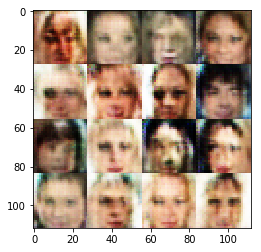

Epoch 2/2... 0.95%... Discriminator Loss: 1.2481... Generator Loss: 0.6384
Epoch 2/2... 1.90%... Discriminator Loss: 1.6091... Generator Loss: 0.6018
Epoch 2/2... 2.84%... Discriminator Loss: 0.9540... Generator Loss: 0.9537
Epoch 2/2... 3.79%... Discriminator Loss: 0.8228... Generator Loss: 1.7064
Epoch 2/2... 4.74%... Discriminator Loss: 0.8880... Generator Loss: 1.1501
Epoch 2/2... 5.69%... Discriminator Loss: 1.0228... Generator Loss: 1.8522
Epoch 2/2... 6.64%... Discriminator Loss: 0.6543... Generator Loss: 1.9395
Epoch 2/2... 7.59%... Discriminator Loss: 1.1094... Generator Loss: 1.5710
Epoch 2/2... 8.53%... Discriminator Loss: 1.2313... Generator Loss: 0.6889
Epoch 2/2... 9.48%... Discriminator Loss: 0.6885... Generator Loss: 1.7013
Epoch 2/2... 10.43%... Discriminator Loss: 1.8237... Generator Loss: 0.3431
Epoch 2/2... 11.38%... Discriminator Loss: 1.0773... Generator Loss: 1.2021
Epoch 2/2... 12.33%... Discriminator Loss: 1.0258... Generator Loss: 1.1884
Epoch 2/2... 13.27%...

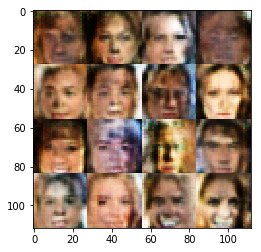

Epoch 2/2... 20.86%... Discriminator Loss: 1.1433... Generator Loss: 1.3667
Epoch 2/2... 21.81%... Discriminator Loss: 1.0970... Generator Loss: 1.0256
Epoch 2/2... 22.76%... Discriminator Loss: 1.4153... Generator Loss: 0.4306
Epoch 2/2... 23.70%... Discriminator Loss: 1.3765... Generator Loss: 0.7261
Epoch 2/2... 24.65%... Discriminator Loss: 1.1486... Generator Loss: 1.5093
Epoch 2/2... 25.60%... Discriminator Loss: 1.1641... Generator Loss: 1.0094
Epoch 2/2... 26.55%... Discriminator Loss: 0.7652... Generator Loss: 1.8339
Epoch 2/2... 27.50%... Discriminator Loss: 0.8043... Generator Loss: 1.3321
Epoch 2/2... 28.45%... Discriminator Loss: 1.3616... Generator Loss: 0.5889
Epoch 2/2... 29.39%... Discriminator Loss: 0.8862... Generator Loss: 1.1948
Epoch 2/2... 30.34%... Discriminator Loss: 0.8569... Generator Loss: 3.7660
Epoch 2/2... 31.29%... Discriminator Loss: 0.8814... Generator Loss: 0.9978
Epoch 2/2... 32.24%... Discriminator Loss: 0.6928... Generator Loss: 1.2275
Epoch 2/2...

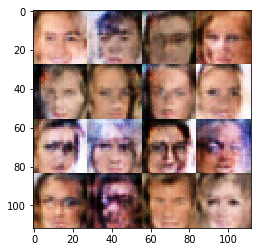

Epoch 2/2... 40.77%... Discriminator Loss: 0.9353... Generator Loss: 0.8886
Epoch 2/2... 41.72%... Discriminator Loss: 0.9532... Generator Loss: 0.9648
Epoch 2/2... 42.67%... Discriminator Loss: 0.9079... Generator Loss: 1.3332
Epoch 2/2... 43.62%... Discriminator Loss: 1.2204... Generator Loss: 0.6824
Epoch 2/2... 44.56%... Discriminator Loss: 0.9778... Generator Loss: 0.9909
Epoch 2/2... 45.51%... Discriminator Loss: 0.8155... Generator Loss: 1.3573
Epoch 2/2... 46.46%... Discriminator Loss: 0.9752... Generator Loss: 1.6293
Epoch 2/2... 47.41%... Discriminator Loss: 1.0302... Generator Loss: 2.8381
Epoch 2/2... 48.36%... Discriminator Loss: 1.0035... Generator Loss: 1.0119
Epoch 2/2... 49.30%... Discriminator Loss: 0.6727... Generator Loss: 1.4006
Epoch 2/2... 50.25%... Discriminator Loss: 0.8568... Generator Loss: 1.9398
Epoch 2/2... 51.20%... Discriminator Loss: 0.7025... Generator Loss: 1.1170
Epoch 2/2... 52.15%... Discriminator Loss: 0.7509... Generator Loss: 1.7086
Epoch 2/2...

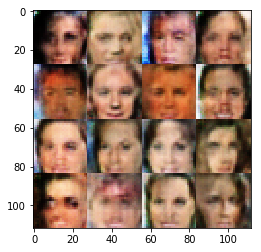

Epoch 2/2... 60.68%... Discriminator Loss: 0.8996... Generator Loss: 1.0768
Epoch 2/2... 61.63%... Discriminator Loss: 0.7005... Generator Loss: 1.1831
Epoch 2/2... 62.58%... Discriminator Loss: 1.1060... Generator Loss: 0.5606
Epoch 2/2... 63.53%... Discriminator Loss: 0.9796... Generator Loss: 1.3186
Epoch 2/2... 64.48%... Discriminator Loss: 0.8540... Generator Loss: 1.0199
Epoch 2/2... 65.42%... Discriminator Loss: 0.9276... Generator Loss: 1.0584
Epoch 2/2... 66.37%... Discriminator Loss: 1.1208... Generator Loss: 1.1478
Epoch 2/2... 67.32%... Discriminator Loss: 0.9923... Generator Loss: 0.6777
Epoch 2/2... 68.27%... Discriminator Loss: 0.4602... Generator Loss: 2.1476
Epoch 2/2... 69.22%... Discriminator Loss: 0.8607... Generator Loss: 0.8090
Epoch 2/2... 70.16%... Discriminator Loss: 0.8714... Generator Loss: 1.2241
Epoch 2/2... 71.11%... Discriminator Loss: 1.4286... Generator Loss: 1.3988
Epoch 2/2... 72.06%... Discriminator Loss: 1.1192... Generator Loss: 1.3408
Epoch 2/2...

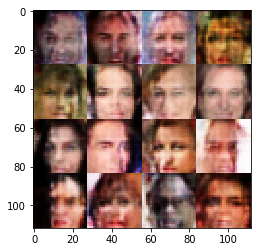

Epoch 2/2... 80.59%... Discriminator Loss: 1.1957... Generator Loss: 0.6936
Epoch 2/2... 81.54%... Discriminator Loss: 0.6835... Generator Loss: 1.3737
Epoch 2/2... 82.49%... Discriminator Loss: 0.8398... Generator Loss: 1.5486
Epoch 2/2... 83.44%... Discriminator Loss: 1.2050... Generator Loss: 0.6547
Epoch 2/2... 84.39%... Discriminator Loss: 0.9152... Generator Loss: 1.0349
Epoch 2/2... 85.34%... Discriminator Loss: 0.9849... Generator Loss: 1.1618
Epoch 2/2... 86.28%... Discriminator Loss: 1.0260... Generator Loss: 1.5540
Epoch 2/2... 87.23%... Discriminator Loss: 0.8485... Generator Loss: 1.2905
Epoch 2/2... 88.18%... Discriminator Loss: 1.2587... Generator Loss: 0.5588
Epoch 2/2... 89.13%... Discriminator Loss: 0.5906... Generator Loss: 1.4424
Epoch 2/2... 90.08%... Discriminator Loss: 0.8548... Generator Loss: 1.8084
Epoch 2/2... 91.02%... Discriminator Loss: 1.1433... Generator Loss: 0.5825
Epoch 2/2... 91.97%... Discriminator Loss: 0.4541... Generator Loss: 3.9004
Epoch 2/2...

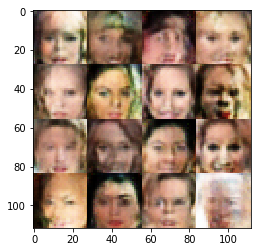

finished training...


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.7


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.